# hypothesis Testing (CORE)
**Marco Jimenez 7/13/2022**

In [247]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [248]:
# Loading data
df = pd.read_csv('Data/insurance.csv') 
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Q1. Do smokers have higher insurance charges than non-smokers?

- $H_0$ (Null Hypothesis): Insurance charges are the same for smokers and non-smokers
- $H_A$ (Alternative Hypothesis): Insurance charges are significantly different for smokers and non-smokers

The appropriate test for this hypothesis is a 2 Sample T-Test with the following assumptions
   - No significant outliers
   - Normality
   - Equal Variance

## Creating groups

In [249]:
df['is_smoker'] = df['smoker'].str.contains('yes', case=False)
df.head()

,age,sex,bmi,children,smoker,region,charges,is_smoker
0,19,female,27.900,0,yes,southwest,16884.92400,True
1,18,male,33.770,1,no,southeast,1725.55230,False
2,28,male,33.000,3,no,southeast,4449.46200,False
3,33,male,22.705,0,no,northwest,21984.47061,False
4,32,male,28.880,0,no,northwest,3866.85520,False


In [250]:
# Separating groups into two variables
smokers = df.loc[df['is_smoker']==True, ['charges','is_smoker']]
non_smoker = df.loc[df['is_smoker']==False, ['charges','is_smoker']]

print(f"There are {len(smokers)} smokers." )
print(f"There are {len(non_smokers)} non smokers." )

There are 274 smokers.
There are 1064 non smokers.


In [251]:
# Creating features for testing
smokers_grp = smokers['charges']
non_smokers_grp = non_smoker['charges']

## 2 Sample t-test

### Assumption 1: No significant outliers

In [252]:
# Testing for outliers in smokers group
outliers_y = np.abs(stats.zscore(smokers_grp)) > 3
outliers_y.sum()

0

In [253]:
# Testing for outliers in non_smokers group
outliers_n = np.abs(stats.zscore(non_smokers_grp)) > 3
outliers_n.sum()

24

In [254]:
# Removing outliers from non_smokers group
non_smokers_grp.loc[~outliers_n]

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1040, dtype: float64

> The outliers have been removed and now the data meets the assumption of no outliers

### Assumption 2: Normality

In [255]:
# Checking distribution in smokers group
result = stats.normaltest(smokers_grp)
print(result)
result.pvalue < .05 

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)


True

In [256]:
# Checking distribution in smokers group
result = stats.normaltest(non_smokers_grp)
print(result)
result.pvalue < .05 

NormaltestResult(statistic=316.4528082392722, pvalue=1.9193129759002216e-69)


True

> Both groups returned a p-value that is less than .05. I therefore conclude that the assumption was not met and that the groups are NOT normally distributed. However, according to the hypothesis testing guide, the sample sizes are large enough to proceed without meeting the assumption of normal distribution.

### Assumption 3: Equal Variance

In [257]:
# Checking variance w/ stats.levene test
result = stats.levene(smokers_grp, non_smokers_grp)
print(result)
result.pvalue<.05

LeveneResult(statistic=332.6135162726081, pvalue=1.5593284881803726e-66)


True

> The stats.levene test returned a p-value that is less than .05. I therefore conclude that the assumption was not met and that the two groups do NOT have equal variance.

## Statistical Test

> Since the two groups did not meet the assumption of equal variance, I will run the stats.ttest using equal_var=False, making it a Welch's T-test to account for the unequal variance

In [258]:
result = stats.ttest_ind(smokers_grp, non_smokers_grp, equal_var=False)
print(result)
result.pvalue<.05

Ttest_indResult(statistic=32.751887766341824, pvalue=5.88946444671698e-103)


True

## Q1 Conclusion

- The Welch's T-test returned a p-value that is less than .05. I therefore reject the null hypothesis and support the alternative hypothesis that Insurance charges are significantly different for smokers and non-smokers.

In [259]:
# Displaying average insurance charges for each group
print(f'Average insurance charges for smokers {smokers_grp.mean():.2f}')
print(f'Average insurance charges for non_smokers {non_smokers_grp.mean():.2f}')

Average insurance charges for smokers 32050.23
Average insurance charges for non_smokers 8434.27


> Smokers on average are charged significantly higher amounts than non smokers

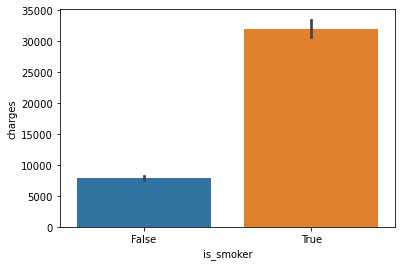

In [260]:
# Visualizing the difference
plot = pd.concat([smokers.loc[~outliers_y],
                  non_smoker.loc[~outliers_n]])
sns.barplot(data=plot, x='is_smoker', y='charges')

# Q2. Are men more likely to smoke than women?

- $H_0$ (Null Hypothesis): There is no relationship between sex and if someone is a smoker.
- $H_A$ (Alternative Hypothesis): A persons sex influences whether or not they are a smoker.

The appropriate test for this hypothesis is a Chi-Squared test with the following assumptions
   - There are two categorical values(ordinal or nominal)
   - The outcomes are independent

### Chi-Squared Test

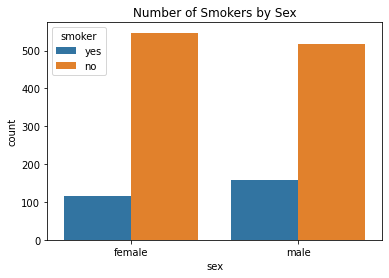

In [261]:
# Visualizing smokers grouped by sex
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");

In [262]:
# Calculating contingency table
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [263]:
# Running stats.chi2 test and saving output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [264]:
# Checking p-value after test
print(p)
p<.05

0.006548143503580696


True

## Conclusion

- The Chi-Squared test returned a p-value that is less than .05. I therefore reject the null hypothesis and support the alternative hypothesis that a persons sex influences whether or not they are a smoker.

# Q3. Do different regions have different charges, on average?

- $H_0$ (Null Hypothesis): There is no difference in insurance charges based on region.
- $H_A$ (Alternative Hypothesis): There is a significant difference in insurance charges based on region.

The appropriate test for this hypothesis is a One Way ANOVA test with the following assumptions
   - Normality
   - Equal Variance
   - No significant outliers

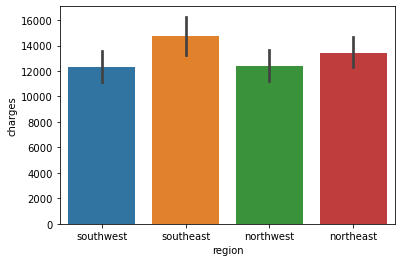

In [265]:
# Visualizing the groups
sns.barplot(data=df, x='region', y='charges');

In [266]:
# Creating a dictionary for the groups
groups = {}
# Looping through all unique categories
for i in df['region'].unique():
    # Getting series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # Saving to dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

## Testing Assumptions

### Assumption 1: Normality

In [267]:
# Running a for loop to normaltest each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    # Saving the p-value, test stat, and group size
    norm_results[i] = {'n': len(data),
                       'p':p,
                       'test stat':stat,}
# Converting result to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [268]:
## checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


> All groups returned a p-value that is less than .05. I therefore conclude that the assumption was not met and that the groups are NOT normally distributed. However, according to the hypothesis testing guide, the sample sizes are large enough to proceed without meeting the assumption of normal distribution.

### Assumption 2: Equal Variance

In [269]:
# Running levene test with the '*' operator to iterate through each group
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

> The stats.levene test returned a p-value that is less than .05. I therefore conclude that the assumption was not met and that the groups do NOT have equal variance.

### One-Way ANOVA Test

In [270]:
# Running oneway ANOVA hypothesis test
result = stats.f_oneway(*groups.values())
result

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

> The Oneway ANOVA test returned a significant result but does not specify which regiens were different. So a pairwise  comparison test will need to be performed.

### Tukey's pairwise Multiple Comparison Test

In [271]:
# Saving the values as charges and the labels to the regions
values = df['charges']
labels = df['region']

In [272]:
# Performing multiple comparison test
tukeys_results = pairwise_tukeyhsd(values, labels)
# Displaying summary
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


## Conclusion


- The Tukey's multiple comparison test showed that there is a significant difference in the insurance charges between the southeast and southwest regions.